In [1]:
# import os
# os.environ['PYTHON_JULIACALL_HANDLE_SIGNALS'] = 'yes'


import time
import numpy as np
import matplotlib.pyplot as plt
import src.vorpy.vorpy as vp
# import vorpy as vp
# import vormake as vmk

/home/crashoverride/miniforge3/envs/2024_05_work/lib/python3.12/site-packages/juliacall/__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
* Creating new Julia namespace...
* Getting path to julia_fns...
* Path to julia_fns: /home/crashoverride/Dropbox/code/vorpy/julia_fns
* Setting JULIA_FNS variable in Julia...
* Trying to run julia_env.jl in /home/crashoverride/Dropbox/code/vorpy/julia_fns...
* Julia environment variables loaded for Vorpy.
* Activating vorpy Julia project...
* Loading CUDA Biot-Savart solver (this may take a few seconds)...


  Activating project at `~/Dropbox/code/vorpy/julia_fns`


Max number of thread: 384
Register usage: 136
* CUDA Biot-Savart solver loaded.
* Loading CPU Biot-Savart solver...
Memory usage: (local = 480, shared = 0, constant = 0)
-> Elapsed time for importing weighted_biot_savart_solver_one_field_point.jl: 0.13606404
* CPU Biot-Savart solver loaded.
!! User API to Biot-Savart solvers set up. Available devices: ['cuda', 'cpu']


In [2]:
# vmk.vortex_ring(100, [0, 0, 0], 1)

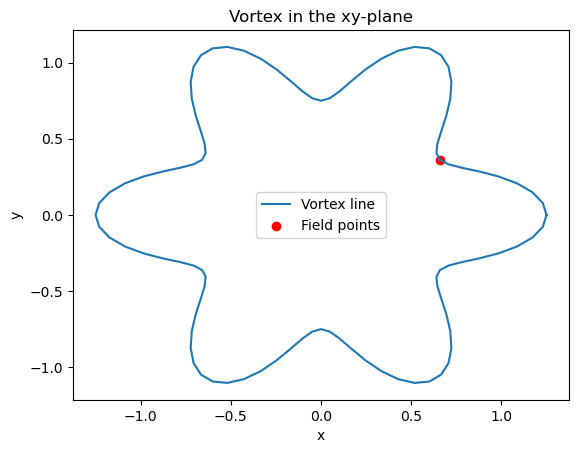

In [3]:
###### Make a vortex ######
NUMSEGS = 100
phi = np.linspace(0, 2*np.pi, NUMSEGS+1)
r = 1 + 0.25 * np.cos(6*phi)
vppsx = r*np.cos(phi)
vppsy = r*np.sin(phi)
vpps = np.zeros((NUMSEGS+1, 3), dtype=float)
vpps[:, 0] = vppsx
vpps[:, 1] = vppsy
# Set the first and last point to be the same
# to close the vortex line
vpps[-1, :] = vpps[0, :]

# Set the core radii and circulations
crads = np.ones(NUMSEGS+1, dtype=float)
circs = np.ones(NUMSEGS+1, dtype=float)

# Plot the vortex line
plt.plot(vpps[:, 0], vpps[:, 1], label='Vortex line')
plt.title('Vortex in the xy-plane')
plt.xlabel('x')
plt.ylabel('y')


###### Make field points ######
fps = vpps[8, :].reshape(1, 3)
# fps = vpps.copy() 
# fps = np.zeros((3, 3), dtype=float)
# fps[0, :] = vpps[0, :]
# fps[1, :] = vpps[9, :]
# fps[2, :] = vpps[21, :]

# Plot the field points
plt.scatter(fps[:, 0], fps[:, 1], color='r', label='Field points')

plt.legend()
plt.show()

In [4]:
# vels = vp.wbs_solve(fps,
#                     vpps,
#                     crads,
#                     circs,
#                     device='cuda',
#                     stepsizescalar=0.001)

# print('vels:\n', vels)

# I know from the eps() function in Julia that
# the smallest division between two floating
# point numbers that Float32 can represent is
# 1.1920929f-7 and the smallest value for a step
# size is 5*1.1920929f-7.
sizearray = np.linspace(1e-6, 0.4, 1000)

vels = []
times = []
for ssize in sizearray:
    tstart = time.time_ns()
    vels.append(vp.wbs_solve(fps,
                        vpps,
                        crads,
                        circs,
                        device='cuda',
                        stepsizescalar=ssize))
    
    times.append((time.time_ns() - tstart) / 1e9)

times = np.array(times)
vels = np.array(vels)

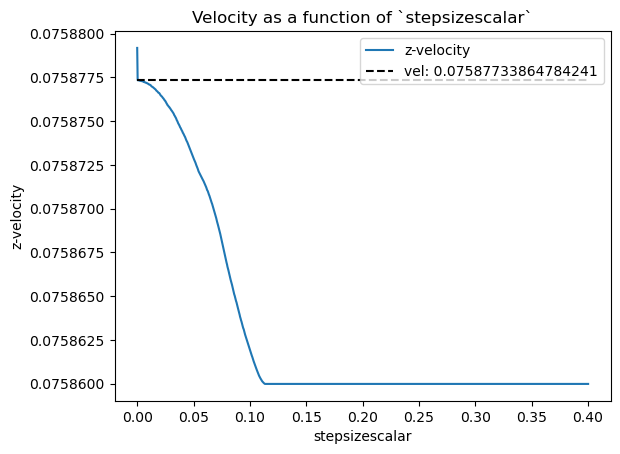

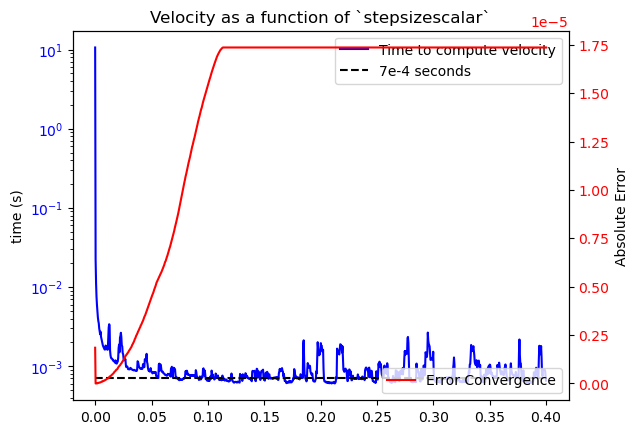

In [5]:
VEL = vels[1, 0, 2]
plt.plot(sizearray, vels[:, 0, 2], label='z-velocity')
plt.hlines(VEL, sizearray[0], sizearray[-1], label=f'vel: {VEL}', linestyles='dashed', colors='k') 
plt.title('Velocity as a function of `stepsizescalar`')
plt.xlabel('stepsizescalar')
plt.ylabel('z-velocity')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(sizearray, times, label='Time to compute velocity', color='b')
ax1.hlines(7e-4, sizearray[0], sizearray[-1], label=f'7e-4 seconds', linestyles='dashed', colors='k')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel('time (s)')
ax1.legend()
# Got this info from https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(sizearray, np.abs(vels[:, 0, 2] - VEL), label='Error Convergence', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# ax2.set_ylim(0, 2e-5)
ax2.set_ylabel('Absolute Error')
ax2.legend()
plt.title('Velocity as a function of `stepsizescalar`')
plt.xlabel('stepsizescalar')
# plt.xlim(0, 0.01)
# plt.legend()
plt.show()

In [6]:
# np.max(np.abs(vels[:, 0, 2] - VEL))

In [7]:
# plt.plot(sizearray, np.abs(vels[:, 0, 2] - vels[0, 0, 2]))  # , 'o-')
# plt.xlabel('Value of `stepsizescalar`')
# plt.ylabel('Absolute Error of Velocity at First Field Point')
# plt.title('Convergence of Error as a Function of `stepsizescalar`')
# plt.show()

In [8]:
fpsrnd = np.random.default_rng(1234).uniform(-2, 2, (100_000_000, 3))
# 1_000_000: 0.180010479 s
# 5_000_000: 0.633952514 s
# 10_000_000: 1.257092033 s
# 50_000_000: 6.172140135 s
# 100_000_000: 12.29594602 s



tstart = time.time_ns()

vp.wbs_solve(fpsrnd,
                vpps,
                crads,
                circs,
                device='cuda',
                stepsizescalar=0.05)

print((time.time_ns() - tstart) / 1e9)

12.874805422


In [9]:
# ###### Time the computation ######
# times = []
# numfps_array = np.int64(range(100, 100_000, 1_000))
# for numfps in numfps_array:
#     fpsrnd = np.random.default_rng(1234).uniform(-2, 2, (numfps, 3))

#     tstart = time.time_ns()
#     for ssize in sizearray:
#         vp.wbs_solve(fpsrnd,
#                         vpps,
#                         crads,
#                         circs,
#                         device='cuda',
#                         stepsizescalar=0.05)
    
#     times.append((time.time_ns() - tstart) / 1e9)
#     print('Time to complete', numfps, 'field points:', times[-1], 'seconds')

# times = np.array(times)

# plt.scatter(numfps_array, times)
# plt.xlabel('Number of Field Points')
# plt.ylabel('Time (s)')
# plt.title('Time to Compute Velocity as a Function of Number of Field Points')
# plt.show()



In [11]:
NUMITERS = 100_000
tottime = 0
for i in range(NUMITERS):
    fpsrnd = np.random.default_rng().uniform(-2, 2, (1, 3))
    tstart = time.time_ns()
    vp.wbs_solve(fpsrnd,
                    vpps,
                    crads,
                    circs,
                    device='cuda',
                    stepsizescalar=0.05)

    tottime += time.time_ns() - tstart

print("Average time to compute velocity at a single field point:", tottime / (1e9 * NUMITERS), "seconds")
# 1_000: 0.00079461499 s
# 100_000: 0.00096431385065 s, 0.00090441645436 s

Average time to compute velocity at a single field point: 0.00090441645436 seconds
